# Diagnostic Demand Visualisation by LSOA

This notebook visualises the estimated CT demand per LSOA across the South West region.  
We will:

1. Load spatial CT demand outputs from `estimate_ct_demand_from_gpkg()`
2. Visualise demand as a choropleth map
3. Prepare a base for overlaying LSOA-to-LSOA travel data for network or gravity-style modelling


In [1]:
# ------------------------------------------------------------------
# Step 0 – Imports, File Paths, and Script Path Setup (CT)
# ------------------------------------------------------------------
import os
import sys
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

# Add the 'scripts' folder to Python import path
script_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/scripts"
if script_dir not in sys.path:
    sys.path.append(script_dir)

# File locations
data_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw"

gpkg_path = os.path.join(data_dir, "LSOA_5-year_segment_master.gpkg")
travel_csv_path = os.path.join(data_dir, "LSOA_to_LSOA_complete.csv")
modality_counts_path = os.path.join(data_dir, "modality_procedure_counts_by_age_band_2024.csv")
cdc_path = os.path.join(data_dir, "health_infra/NHS_SW_ Community_Diagnostic_Centres_enriched.csv")
acute_path = os.path.join(data_dir, "health_infra/NHS_SW_Acute_Hospitals_enriched.csv")

# Confirm file existence
for path in [gpkg_path, travel_csv_path, modality_counts_path, cdc_path, acute_path]:
    assert os.path.exists(path), f"Missing file: {path}"

# Utility function to check columns
def print_columns(filepath, is_geopkg=False):
    print(f"\nColumns in: {os.path.basename(filepath)}")
    try:
        if is_geopkg:
            df = gpd.read_file(filepath)
        else:
            df = pd.read_csv(filepath, nrows=5)  # Just preview first few rows for speed
        print(df.columns.tolist())
    except Exception as e:
        print(f"Could not read: {e}")

# Run checks
print_columns(gpkg_path, is_geopkg=True)
print_columns(travel_csv_path)
print_columns(modality_counts_path)
print_columns(cdc_path)
print_columns(acute_path)



Columns in: LSOA_5-year_segment_master.gpkg
['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus', 'lat', 'long', 'bng_e', 'bng_n', 'lsoa21nm', 'geometry']

Columns in: LSOA_to_LSOA_complete.csv
['origin_name', 'destination_name', 'travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak']

Columns in: modality_procedure_counts_by_age_band_2024.csv
['age_band', 'CT_Cancer Pathway', 'CT_Non-Cancer Pathway', 'CT_Total', 'Endoscopy_Cancer Pathway', 'Endoscopy_Non-Cancer Pathway', 'Endoscopy_Total', 'MRI_Cancer Pathway', 'MRI_Non-Cancer Pathway', 'MRI_Total']

Columns in: NHS_SW_ Community_Diagnostic_Centres_enriched.csv
['Code', 'Name', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcod

In [2]:
# ------------------------------------------------------------------
# Step 1 – Load CT Demand Estimates
# ------------------------------------------------------------------
from estimate_ct_demand_from_gpkg import estimate_ct_demand_from_gpkg

ct_demand_df = estimate_ct_demand_from_gpkg()
print("Loaded CT demand per LSOA:")
display(ct_demand_df.head())


Loaded CT demand per LSOA:


,lsoa21cd,ct_total_demand,ct_age_0_4,ct_age_5_9,ct_age_10_14,ct_age_15_19,ct_age_20_24,ct_age_25_29,ct_age_30_34,ct_age_35_39,ct_age_40_44,ct_age_45_49,ct_age_50_54,ct_age_55_59,ct_age_60_64,ct_age_65_69,ct_age_70_74,ct_age_75_79,ct_age_80_84,ct_age_85_plus
0,E01020484,195.135416,0.314717,0.307424,0.647540,1.908021,1.902695,1.707932,3.254599,4.268538,4.500157,6.171343,10.060345,14.501970,21.826293,21.668452,25.234176,27.716494,25.612661,23.532059
1,E01020481,229.178298,0.285446,0.142568,0.349998,0.687899,1.595984,1.784022,2.453117,2.595702,3.643085,4.187388,6.393974,15.019852,27.811312,27.294920,35.824249,36.487580,24.788541,37.832659
2,E01020482,208.131320,0.504942,0.338644,0.638768,1.042859,2.025440,2.884723,4.811670,4.672717,6.285900,6.465182,8.556098,16.444982,26.050402,21.252814,29.290420,32.629544,20.241675,23.994539
3,E01020479,236.957728,0.241504,0.142568,0.279999,1.020620,1.012720,1.366271,1.697991,1.615015,2.071434,3.673350,4.701234,9.841032,13.554512,21.668452,23.657732,41.400630,38.421021,70.591643
4,E01020478,167.844266,0.270775,0.196032,0.446312,1.286840,1.442478,1.214463,1.886657,2.826419,4.000374,4.040829,7.616405,13.336417,16.017711,18.335159,20.954308,28.768059,19.827585,25.377444


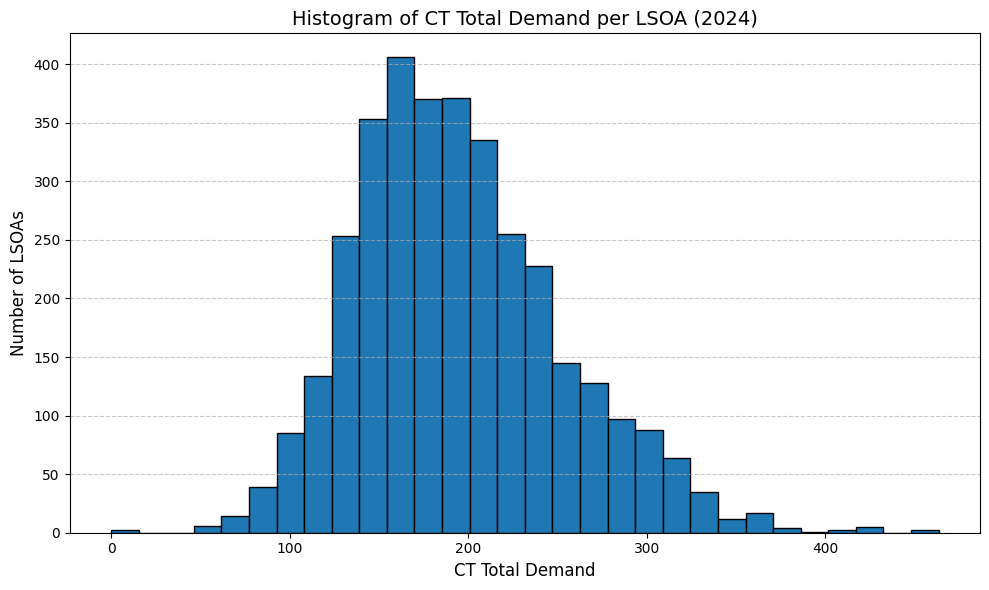

In [3]:
# ------------------------------------------------------------------
# Step 1a – Histogram of CT Total Demand per LSOA
# ------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.hist(ct_demand_df["ct_total_demand"], bins=30, edgecolor='black')

plt.title("Histogram of CT Total Demand per LSOA (2024)", fontsize=14)
plt.xlabel("CT Total Demand", fontsize=12)
plt.ylabel("Number of LSOAs", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [4]:
# ------------------------------------------------------------------
# Step 1b – Check for LSOAs with Zero or Very Low CT Demand
# ------------------------------------------------------------------
zero_demand = ct_demand_df[ct_demand_df["ct_total_demand"] == 0]
print(f"LSOAs with zero CT demand: {len(zero_demand)}")
print(zero_demand)

# Optional: Check for LSOAs with very low demand (e.g., less than 5)
low_demand = ct_demand_df[ct_demand_df["ct_total_demand"] < 5]
print(f"\nLSOAs with very low CT demand (< 5): {len(low_demand)}")
print(low_demand)


LSOAs with zero CT demand: 2
       lsoa21cd  ct_total_demand  ct_age_0_4  ct_age_5_9  ct_age_10_14  \
2010  W01001595              0.0         NaN         NaN           NaN   
2011  W01001599              0.0         NaN         NaN           NaN   

      ct_age_15_19  ct_age_20_24  ct_age_25_29  ct_age_30_34  ct_age_35_39  \
2010           NaN           NaN           NaN           NaN           NaN   
2011           NaN           NaN           NaN           NaN           NaN   

      ct_age_40_44  ct_age_45_49  ct_age_50_54  ct_age_55_59  ct_age_60_64  \
2010           NaN           NaN           NaN           NaN           NaN   
2011           NaN           NaN           NaN           NaN           NaN   

      ct_age_65_69  ct_age_70_74  ct_age_75_79  ct_age_80_84  ct_age_85_plus  
2010           NaN           NaN           NaN           NaN             NaN  
2011           NaN           NaN           NaN           NaN             NaN  

LSOAs with very low CT demand (< 5): 2
 

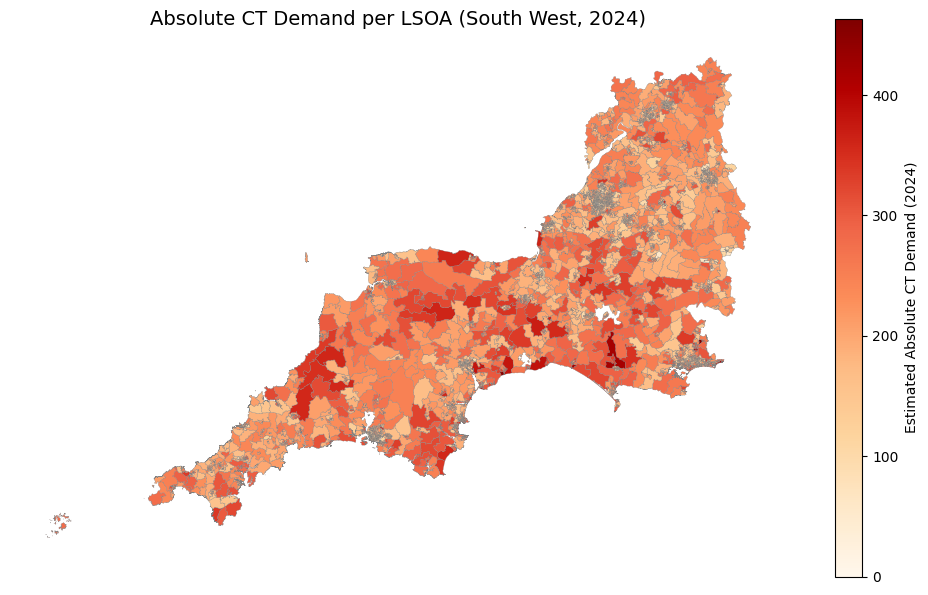

In [5]:
# ------------------------------------------------------------------
# Step 2 – Choropleth of Absolute CT Demand per LSOA (2024, 300 DPI)
# ------------------------------------------------------------------

# Reload GPKG with geometry
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# Merge with CT demand
gdf_ct = gdf_geom.merge(
    ct_demand_df[["lsoa21cd", "ct_total_demand"]],
    on="lsoa21cd",
    how="left"
)

# Plot choropleth
fig, ax = plt.subplots(figsize=(10, 6))  # shorter height for cleaner layout
gdf_ct.plot(
    column="ct_total_demand",
    cmap="OrRd",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Estimated Absolute CT Demand (2024)"},
    ax=ax
)

ax.set_title("Absolute CT Demand per LSOA (South West, 2024)", fontsize=14)
ax.axis("off")
plt.tight_layout()

# Save at high resolution (optional)
output_path = "ct_demand_absolute_choropleth_2024.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()


In [13]:
# ------------------------------------------------------------------
# Step 3 – Compute Nearest Diagnostic Site (CDC or Acute) by Car Travel Time
# ------------------------------------------------------------------

# Load LSOA-to-LSOA travel matrix (with unnamed columns)
travel_df = pd.read_csv(travel_csv_path, header=None)
travel_df.columns = [
    "origin_lsoa",
    "dest_lsoa",
    "car_travel_minutes",
    "placeholder_1",
    "placeholder_2"
]

# Ensure correct data types
travel_df["car_travel_minutes"] = pd.to_numeric(travel_df["car_travel_minutes"], errors="coerce")
travel_df["origin_lsoa"] = travel_df["origin_lsoa"].astype(str)
travel_df["dest_lsoa"] = travel_df["dest_lsoa"].astype(str)

# Load and tag Community Diagnostic Centres (CDC) and Acute sites
cdc_df = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)

facilities_df = pd.concat([
    cdc_df[["Name", "lsoa21cd"]].assign(facility_type="CDC"),
    acute_df[["Name", "lsoa21cd"]].assign(facility_type="Acute")
], ignore_index=True).dropna(subset=["lsoa21cd"]).drop_duplicates()

facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Join travel matrix with facility locations
nearest_candidates = travel_df.merge(
    facilities_df,
    left_on="dest_lsoa",
    right_on="lsoa21cd",
    how="inner"
).drop(columns=["lsoa21cd"])  # remove duplicate column after merge

# Identify the nearest site by shortest travel time for each origin LSOA
nearest_sites = (
    nearest_candidates
    .sort_values("car_travel_minutes")
    .groupby("origin_lsoa")
    .first()
    .reset_index()
    .rename(columns={
        "origin_lsoa": "lsoa21cd",
        "Name": "nearest_site",
        "facility_type": "nearest_type",
        "car_travel_minutes": "travel_to_nearest_mins"
    })[[
        "lsoa21cd",
        "nearest_site",
        "nearest_type",
        "travel_to_nearest_mins"
    ]]
)

# Merge nearest site info with CT demand GeoDataFrame
gdf_ct["lsoa21cd"] = gdf_ct["lsoa21cd"].astype(str)
nearest_sites["lsoa21cd"] = nearest_sites["lsoa21cd"].astype(str)

gdf_ct = gdf_ct.merge(nearest_sites, on="lsoa21cd", how="left")

# Tag if the LSOA contains a facility (i.e., 0 min travel time)
facility_lsoas = set(facilities_df["lsoa21cd"])
gdf_ct["facility_onsite"] = gdf_ct["lsoa21cd"].isin(facility_lsoas)

# Preview result
gdf_ct[[
    "lsoa21cd",
    "ct_total_demand",
    "nearest_site",
    "nearest_type",
    "travel_to_nearest_mins",
    "facility_onsite"
]].head()


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_7648/2938188745.py:6: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  travel_df = pd.read_csv(travel_csv_path, header=None)


,lsoa21cd,ct_total_demand,nearest_site,nearest_type,travel_to_nearest_mins,facility_onsite
0,E01020484,195.135416,Dorset Health Village Poole Beales CDC,CDC,37.262783,False
1,E01020481,229.178298,Dorset Health Village Poole Beales CDC,CDC,40.298602,False
2,E01020482,208.131320,Dorset Health Village Poole Beales CDC,CDC,37.925839,False
3,E01020479,236.957728,Dorset Health Village Poole Beales CDC,CDC,38.583952,False
4,E01020478,167.844266,Dorset Health Village Poole Beales CDC,CDC,36.993783,False


In [ ]:
# Set style
plt.style.use("seaborn-v0_8-muted")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Define histogram settings
bins = 30
alpha = 0.8

# 1. Car travel time
axes[0].hist(
    gdf_ct["travel_to_nearest_mins"].dropna(),
    bins=bins,
    color="steelblue",
    alpha=alpha,
    edgecolor="black"
)
axes[0].set_title("Travel Time by Car (mins)")
axes[0].set_xlabel("Minutes")
axes[0].set_ylabel("Number of LSOAs")

# 2. Public transport (peak)
axes[1].hist(
    gdf_ct["travel_pt_peak_mins"].dropna(),
    bins=bins,
    color="orange",
    alpha=alpha,
    edgecolor="black"
)
axes[1].set_title("Travel Time by Public Transport (Peak)")
axes[1].set_xlabel("Minutes")

# 3. Public transport (non-peak)
axes[2].hist(
    gdf_ct["travel_pt_nonpeak_mins"].dropna(),
    bins=bins,
    color="seagreen",
    alpha=alpha,
    edgecolor="black"
)
axes[2].set_title("Travel Time by Public Transport (Non-Peak)")
axes[2].set_xlabel("Minutes")

# Final formatting
plt.suptitle("Distribution of Travel Times to Nearest Diagnostic Site", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ------------------------------------------------------------------
# Summary Statistics (printed after the plots)
# ------------------------------------------------------------------
print("\n--- Summary Statistics of Travel Times (in minutes) ---")
print(
    gdf_ct[[
        "travel_to_nearest_mins",
        "travel_pt_peak_mins",
        "travel_pt_nonpeak_mins"
    ]]
    .describe()
    .round(1)
)

# ------------------------------------------------------------------
# Combined Overlaid Histogram of Travel Times
# ------------------------------------------------------------------

plt.figure(figsize=(10, 6))
bins = 30
alpha = 0.5

plt.hist(
    gdf_ct["travel_to_nearest_mins"].dropna(),
    bins=bins,
    color="steelblue",
    alpha=alpha,
    edgecolor="black",
    label="Car"
)

plt.hist(
    gdf_ct["travel_pt_peak_mins"].dropna(),
    bins=bins,
    color="orange",
    alpha=alpha,
    edgecolor="black",
    label="PT (Peak)"
)

plt.hist(
    gdf_ct["travel_pt_nonpeak_mins"].dropna(),
    bins=bins,
    color="seagreen",
    alpha=alpha,
    edgecolor="black",
    label="PT (Non-Peak)"
)

plt.title("Overlaid Distribution of Travel Times to Nearest Diagnostic Site")
plt.xlabel("Travel Time (minutes)")
plt.ylabel("Number of LSOAs")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


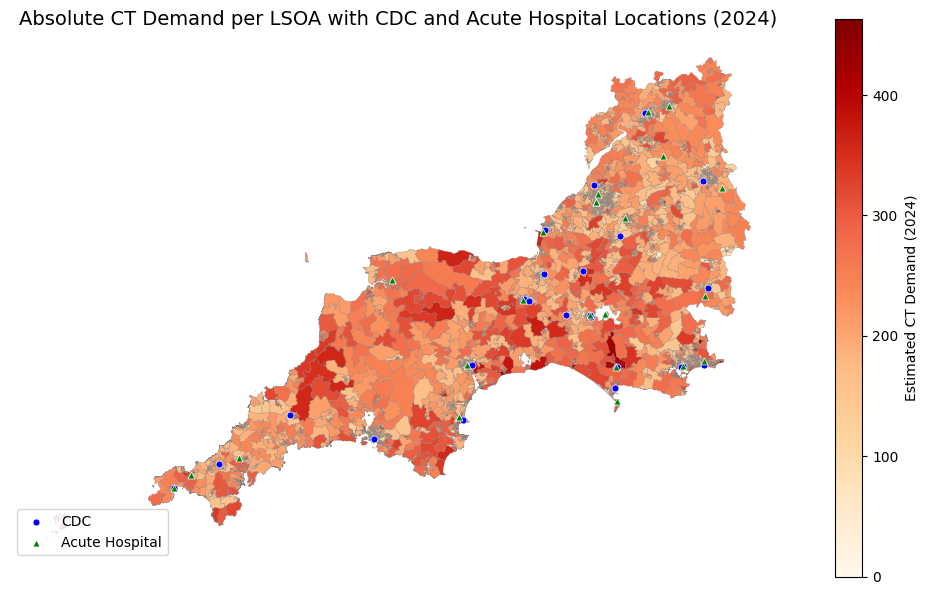

In [89]:
# ------------------------------------------------------------------
# Step 4 – Overlay CT Demand Choropleth with Facility Locations
# ------------------------------------------------------------------

# 4.1 – Rebuild Base CT Demand GeoDataFrame (if needed)
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]
gdf_ct = gdf_geom.merge(
    ct_demand_df[["lsoa21cd", "ct_total_demand"]],
    on="lsoa21cd",
    how="left"
)

# 4.2 – Prepare Facility Point Locations
facilities_df = pd.concat([
    cdc_df.assign(site_type="CDC"),
    acute_df.assign(site_type="Acute")
], ignore_index=True).dropna(subset=["lsoa21cd"]).drop_duplicates()

facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Merge facility records with geometry
facilities_gdf = facilities_df.merge(gdf_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_geom.crs)

# Use centroids for plotting locations
facilities_gdf["centroid"] = facilities_gdf.geometry.centroid
facilities_gdf = facilities_gdf.set_geometry("centroid")

# Split by facility type
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"]
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"]

# 4.3 – Plot CT Demand with Facility Overlays
fig, ax = plt.subplots(figsize=(10, 6))

# Plot CT demand choropleth
gdf_ct.plot(
    column="ct_total_demand",
    cmap="OrRd",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Estimated CT Demand (2024)"},
    ax=ax
)

# Overlay CDCs and Acute Hospitals
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=25,
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)

acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=25,
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Final formatting
ax.set_title("Absolute CT Demand per LSOA with CDC and Acute Hospital Locations (2024)", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("ct_demand_with_facilities_overlay_2024.png", dpi=300, bbox_inches="tight")
plt.show()


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_7648/2683237216.py:114: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower left", frameon=True)


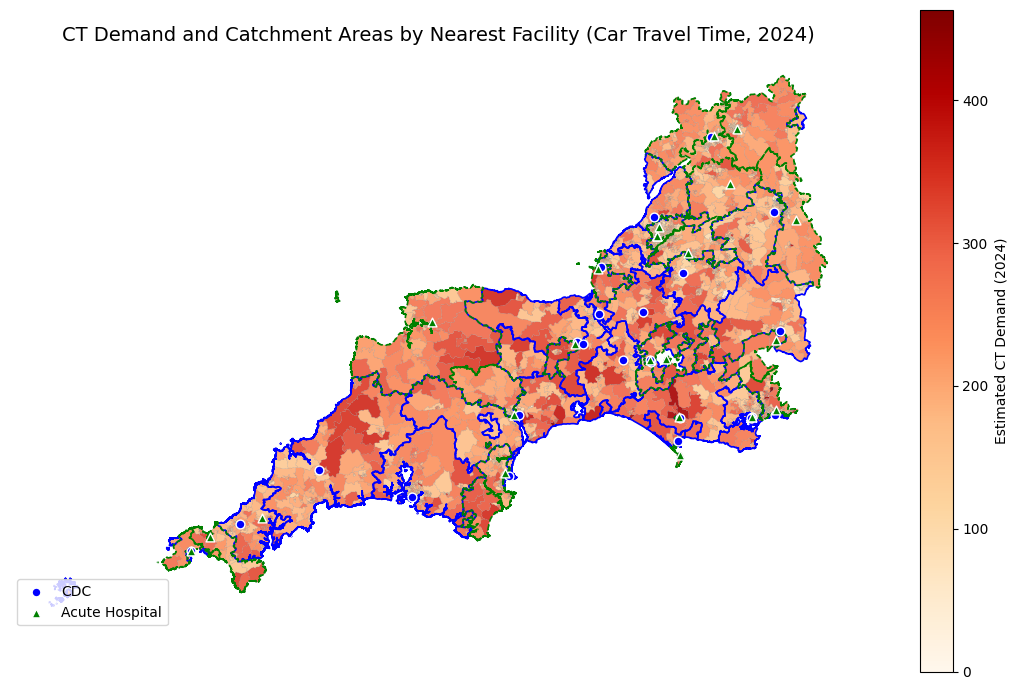

In [8]:
# ------------------------------------------------------------------
# Step 5 – Visualise CT Catchment Areas by Nearest Facility (Car Travel Time)
# ------------------------------------------------------------------

# 5.1 – Load Base Geometry and CT Demand
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]
gdf_ct = gdf_geom.merge(
    ct_demand_df[["lsoa21cd", "ct_total_demand"]],
    on="lsoa21cd",
    how="left"
)

# 5.2 – Merge Nearest Site Assignments (Based on Car Travel Time)
nearest_sites["lsoa21cd"] = nearest_sites["lsoa21cd"].astype(str)
gdf_ct["lsoa21cd"] = gdf_ct["lsoa21cd"].astype(str)

gdf_ct = gdf_ct.merge(
    nearest_sites[[
        "lsoa21cd",
        "nearest_site",
        "nearest_type",
        "travel_to_nearest_mins"
    ]],
    on="lsoa21cd",
    how="left"
)

# 5.3 – Prepare Facility Points
facilities_df = pd.concat([
    cdc_df.assign(site_type="CDC"),
    acute_df.assign(site_type="Acute")
], ignore_index=True).dropna(subset=["lsoa21cd"]).drop_duplicates()

facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

facilities_gdf = facilities_df.merge(gdf_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_geom.crs)

# Use LSOA centroids for plotting points
facilities_gdf["centroid"] = facilities_gdf.geometry.centroid
facilities_gdf = facilities_gdf.set_geometry("centroid")

# Split by type
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"]
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"]

# 5.4 – Create Catchment Polygons by Nearest Facility
catchment_gdf = gdf_ct.dissolve(by="nearest_site", as_index=False)

# Map site type back to catchments
site_type_map = facilities_df.set_index("Name")["site_type"].to_dict()
catchment_gdf["site_type"] = catchment_gdf["nearest_site"].map(site_type_map)

# Split catchments by facility type
catchment_cdc = catchment_gdf[catchment_gdf["site_type"] == "CDC"]
catchment_acute = catchment_gdf[catchment_gdf["site_type"] == "Acute"]

# 5.5 – Plot Demand with Car-Based Catchments and Facilities
fig, ax = plt.subplots(figsize=(11, 7))

# Base: CT demand choropleth
gdf_ct.plot(
    column="ct_total_demand",
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Estimated CT Demand (2024)"},
    ax=ax,
    alpha=0.9
)

# Catchment overlays
catchment_cdc.plot(
    ax=ax,
    facecolor="none",
    edgecolor="blue",
    linewidth=1.2,
    linestyle="-",
    label="CDC Catchment (Car)"
)

catchment_acute.plot(
    ax=ax,
    facecolor="none",
    edgecolor="green",
    linewidth=1.2,
    linestyle="--",
    label="Acute Catchment (Car)"
)

# Facility markers
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=40,
    marker="o",
    edgecolor="white",
    label="CDC"
)

acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=40,
    marker="^",
    edgecolor="white",
    label="Acute Hospital"
)

# Final formatting
ax.set_title("CT Demand and Catchment Areas by Nearest Facility (Car Travel Time, 2024)", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()

# Save output
plt.savefig("ct_demand_with_car_catchments_2024.png", dpi=300, bbox_inches="tight")
plt.show()


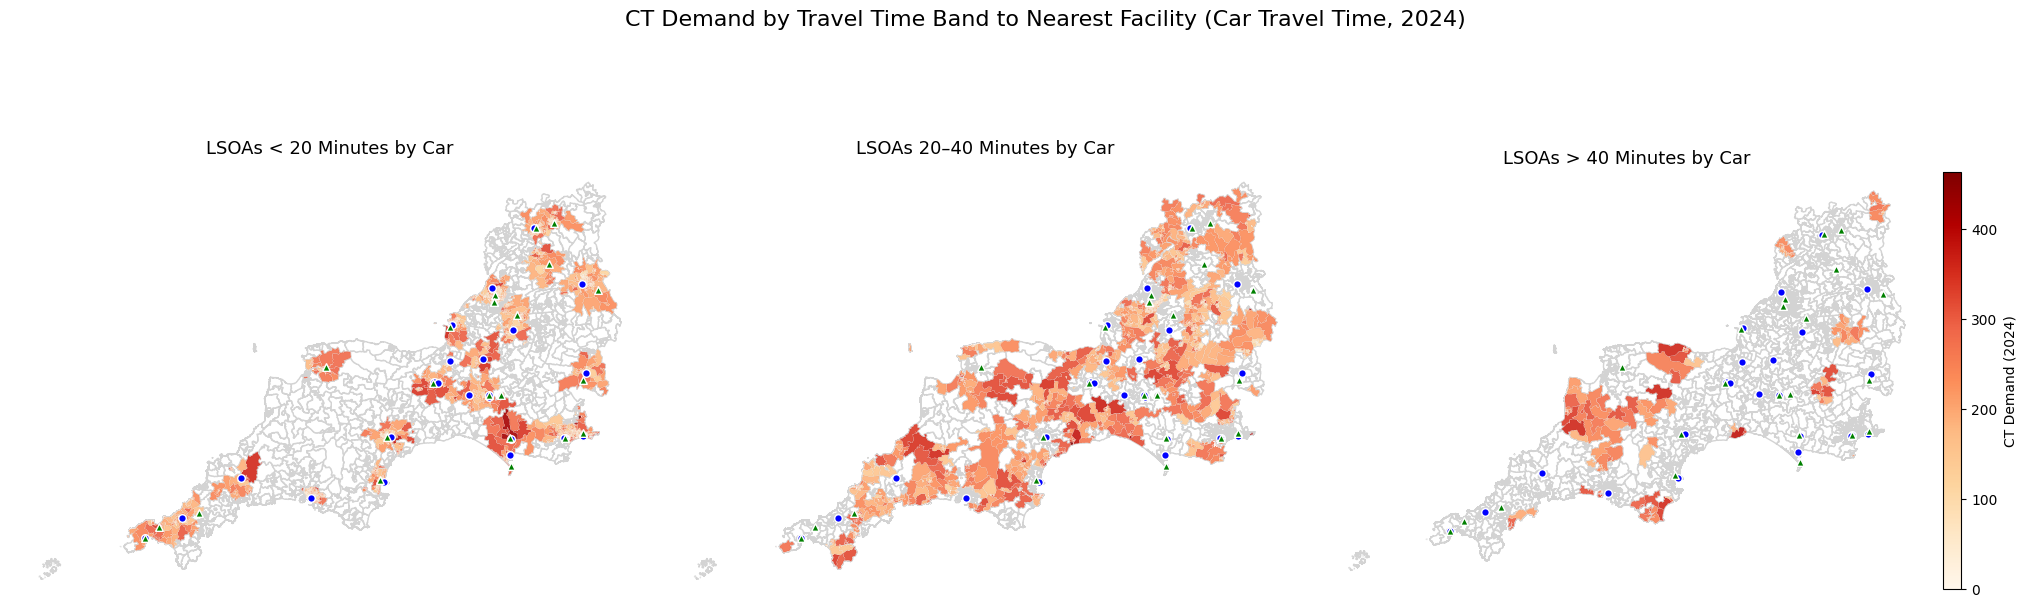

In [11]:
# ----------------------------------------------
# Define travel time bands
# ----------------------------------------------
lt_20 = gdf_ct[gdf_ct["travel_to_nearest_mins"] < 20].copy()
btw_20_40 = gdf_ct[
    (gdf_ct["travel_to_nearest_mins"] >= 20) & 
    (gdf_ct["travel_to_nearest_mins"] <= 40)
].copy()
gt_40 = gdf_ct[gdf_ct["travel_to_nearest_mins"] > 40].copy()

# Use same colour scale across all maps
vmin = gdf_ct["ct_total_demand"].min()
vmax = gdf_ct["ct_total_demand"].max()

# ----------------------------------------------
# Create 3 subplots
# ----------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Shared style
plot_kwargs = dict(
    column="ct_total_demand",
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="white",
    vmin=vmin,
    vmax=vmax,
    alpha=0.9,
    legend=False
)

# Map 1 – <20 mins
gdf_ct.assign(visible=False).plot(ax=axes[0], color="white", edgecolor="lightgrey")
lt_20.plot(ax=axes[0], **plot_kwargs)
cdc_gdf.plot(ax=axes[0], color="blue", markersize=30, marker="o", edgecolor="white", label="CDC")
acute_gdf.plot(ax=axes[0], color="green", markersize=30, marker="^", edgecolor="white", label="Acute")
axes[0].set_title("LSOAs < 20 Minutes by Car", fontsize=13)
axes[0].axis("off")

# Map 2 – 20–40 mins
gdf_ct.assign(visible=False).plot(ax=axes[1], color="white", edgecolor="lightgrey")
btw_20_40.plot(ax=axes[1], **plot_kwargs)
cdc_gdf.plot(ax=axes[1], color="blue", markersize=30, marker="o", edgecolor="white")
acute_gdf.plot(ax=axes[1], color="green", markersize=30, marker="^", edgecolor="white")
axes[1].set_title("LSOAs 20–40 Minutes by Car", fontsize=13)
axes[1].axis("off")

# Map 3 – >40 mins
gdf_ct.assign(visible=False).plot(ax=axes[2], color="white", edgecolor="lightgrey")
gt_40.plot(ax=axes[2], **plot_kwargs)
cdc_gdf.plot(ax=axes[2], color="blue", markersize=30, marker="o", edgecolor="white")
acute_gdf.plot(ax=axes[2], color="green", markersize=30, marker="^", edgecolor="white")
axes[2].set_title("LSOAs > 40 Minutes by Car", fontsize=13)
axes[2].axis("off")

# ----------------------------------------------
# Add a shared colourbar
# ----------------------------------------------
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="3%", pad=0.1)

gdf_ct.plot(
    column="ct_total_demand",
    cmap="OrRd",
    ax=axes[2],
    alpha=0,  # dummy plot for colorbar
    legend=True,
    cax=cax,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={"label": "CT Demand (2024)"}
)

# Final layout
plt.suptitle("CT Demand by Travel Time Band to Nearest Facility (Car Travel Time, 2024)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.97, 0.95])
plt.savefig("ct_demand_travel_time_band_maps_2024.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ----------------------------------------------
# Assign PT Travel Time Bands
# ----------------------------------------------
def assign_band(val):
    if pd.isna(val):
        return None
    if val <= 25:
        return "Very Good"
    elif val <= 40:
        return "Good"
    elif val <= 60:
        return "Moderate"
    elif val <= 90:
        return "Poor"
    else:
        return "Very Poor"

gdf_ct["pt_peak_band"] = gdf_ct["travel_pt_peak_mins"].apply(assign_band)
gdf_ct["pt_nonpeak_band"] = gdf_ct["travel_pt_nonpeak_mins"].apply(assign_band)

# ----------------------------------------------
# CT demand scale for all plots
# ----------------------------------------------
vmin = gdf_ct["ct_total_demand"].min()
vmax = gdf_ct["ct_total_demand"].max()

# Band order and labels
band_order = ["Very Good", "Good", "Moderate", "Poor", "Very Poor"]
band_ranges = {
    "Very Good": "0–25 mins",
    "Good": "25–40 mins",
    "Moderate": "40–60 mins",
    "Poor": "60–90 mins",
    "Very Poor": ">90 mins"
}

# Shared style for plots
plot_kwargs = dict(
    column="ct_total_demand",
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="white",
    vmin=vmin,
    vmax=vmax,
    alpha=0.9,
    legend=False
)

# ----------------------------------------------
# Create 5×2 Grid of Maps
# ----------------------------------------------
fig, axes = plt.subplots(5, 2, figsize=(14, 24))

for row, band in enumerate(band_order):
    for col, mode in enumerate(["pt_peak_band", "pt_nonpeak_band"]):
        ax = axes[row, col]

        # Plot all LSOAs as background (white)
        gdf_ct.assign(dummy=0).plot(ax=ax, color="white", edgecolor="lightgrey")

        # Overlay selected band only
        gdf_ct[gdf_ct[mode] == band].plot(ax=ax, **plot_kwargs)

        # Facility markers
        cdc_gdf.plot(ax=ax, color="blue", markersize=30, marker="o", edgecolor="white")
        acute_gdf.plot(ax=ax, color="green", markersize=30, marker="^", edgecolor="white")

        # Titles
        mode_label = "PT Peak" if col == 0 else "PT Non-Peak"
        band_label = f"{band} Access ({band_ranges[band]})"
        ax.set_title(f"{band_label}\n{mode_label}", fontsize=12)
        ax.axis("off")

# ----------------------------------------------
# Shared Colourbar
# ----------------------------------------------
divider = make_axes_locatable(axes[4, 1])
cax = divider.append_axes("right", size="3%", pad=0.1)

gdf_ct.plot(
    column="ct_total_demand",
    cmap="OrRd",
    ax=axes[4, 1],
    alpha=0,
    legend=True,
    cax=cax,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={"label": "CT Demand (2024)"}
)

# ----------------------------------------------
# Final Layout
# ----------------------------------------------
plt.suptitle("CT Demand by Public Transport Travel Time Bands (Peak & Non-Peak, 2024)", fontsize=18)
plt.tight_layout(rect=[0, 0, 0.97, 0.96])
plt.savefig("ct_demand_pt_peak_nonpeak_bands_5x2_2024.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import seaborn as sns
import numpy as np

# ------------------------------------------------------------------
# KDE Plot for All Travel Time Modes (Car + PT Peak + PT Non-Peak)
# ------------------------------------------------------------------

plt.figure(figsize=(10, 6))

# 1. Car travel time
sns.kdeplot(
    data=gdf_ct,
    x="travel_to_nearest_mins",
    label="Car",
    color="steelblue",
    linewidth=2
)

# 2. PT Peak
sns.kdeplot(
    data=gdf_ct,
    x="travel_pt_peak_mins",
    label="PT Peak",
    color="orange",
    linewidth=2
)

# 3. PT Non-Peak
sns.kdeplot(
    data=gdf_ct,
    x="travel_pt_nonpeak_mins",
    label="PT Non-Peak",
    color="seagreen",
    linewidth=2
)

# 4. PT Peak (log)
sns.kdeplot(
    data=gdf_ct[gdf_ct["travel_pt_peak_mins"] > 0],
    x=np.log1p(gdf_ct["travel_pt_peak_mins"]),
    label="PT Peak (log)",
    linestyle="--",
    color="darkorange",
    linewidth=1.5
)

# 5. PT Non-Peak (log)
sns.kdeplot(
    data=gdf_ct[gdf_ct["travel_pt_nonpeak_mins"] > 0],
    x=np.log1p(gdf_ct["travel_pt_nonpeak_mins"]),
    label="PT Non-Peak (log)",
    linestyle="--",
    color="darkgreen",
    linewidth=1.5
)

# Axis labels and legend
plt.title("KDE Comparison of Travel Times to Nearest Diagnostic Site")
plt.xlabel("Travel Time (minutes) / log(minutes)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
